# FAST-EM import
---
**Author**: Ryan Lane  
**Date**: 6 April 2022

#### Overview
Quickly imports a FAST-EM project to `render-ws`.

Assumes data is stored as

Stack | Filepath
- | -
raw | `/.../asm_service/{date}/{project}/{section}/{row}_{col}_{zoom}.tiff`
corrected | `/.../asm_service/{date}/{stack}/{section}/corrected/{row}_{col}_{zoom}.tiff`

and outputs mipmaps of each field's pyramidal tiff to

Stack | Filepath
- | -
raw | `/.../{project}/raw/{section}/{row}_{col}/{zoom}.tif`
corrected | `/.../{project}/corrected/{section}/{row}_{col}/{zoom}.tif`

**Warning**:
Check filepath tree carefully before executing.

In [56]:
from pathlib import Path
import re
from ruamel.yaml import YAML

from tqdm.notebook import tqdm
from bs4 import BeautifulSoup as Soup
import numpy as np
import pandas as pd
from tifffile import TiffFile

import renderapi
import icatapi
from renderapi.transform import AffineModel

In [57]:
# Indirectly enable autocomplete
%config Completer.use_jedi = False

# pandas display options
pd.set_option('display.max_colwidth', 20)

#### Connect to `render-ws`

In [58]:
# render parameters
owner = 'akievits'
project = '20220601_UMCU'

# Create a renderapi.connect.Render object
render_connect_params = {
    'host': 'sonic.tnw.tudelft.nl',
    'port': 8080,
    'owner': owner,
    'project': project,
    'client_scripts': '/home/catmaid/render/render-ws-java-client/src/main/scripts',
    'memGB': '2G',
}
render = renderapi.connect(**render_connect_params)
render.make_kwargs()

{'host': 'http://sonic.tnw.tudelft.nl',
 'port': 8080,
 'owner': 'akievits',
 'project': '20220601_UMCU',
 'client_scripts': '/home/catmaid/render/render-ws-java-client/src/main/scripts',
 'client_script': '/home/catmaid/render/render-ws-java-client/src/main/scripts/run_ws_client.sh',
 'memGB': '2G'}

#### Import and export directories

In [59]:
# Import from
dir_FASTEM = Path('/long_term_storage/asm_storage/asm_service/2022-06-01/20220601_AK_UMCU')
# Export to
dir_project = Path(f"/long_term_storage/{owner}/FAST-EM/{project}/")

# Stack directory
!ls -l $dir_FASTEM

total 20
drwxrwxrwx 3 asmftp asmftp 8192 Jun  1 16:31 HM20_s001
drwxrwxrwx 3 asmftp asmftp 4096 Jun  1 17:33 HM20_s002
drwxrwxrwx 3 asmftp asmftp 4096 Jun  1 18:07 HM20_s003


#### Section mapping

In [62]:
# Assume subdirectories of FAST-EM directories are different sections (durr)
dir_sections = sorted([dir_ for dir_ in dir_FASTEM.iterdir() if dir_.is_dir()])
d_sections = {i: d.name for i, d in enumerate(dir_sections)}
d_sections

# Drop sections that aren't needed
# d_sections.pop(0)
# d_sections.pop(1)

{0: 'HM20_s001', 1: 'HM20_s002', 2: 'HM20_s003'}

## 1) Create mipmaps
---

#### Filepath layout
Mimaps of each FAST-EM field are output to
`{dir_project}/{stack}/{sectionId}/{row}_{col}/{zoom}.tif` e.g.

In [63]:
# %%bash
# ls -l /long_term_storage/rlane/FAST-EM/projects/20220404_02_demo_Brain_10us/raw/Ribbon_1_section_3_ROA-1/003_004/

In [64]:
from tifffile import TiffWriter

def create_mipmaps(tiff, dir_out, metadata):
    """Create mipmaps from multi-page tiff"""
    # Unpack pages
    for i, page in enumerate(tiff.pages):
        # Grayscale uint16 image
        image = page.asarray()
        # Write tiff
        fp = dir_out / f"{i}.tif"
        with TiffWriter(fp.as_posix()) as tif:
            tif.save(image, metadata=metadata)

#### Raw

In [65]:
# Loop through section directories
for z, dir_section in tqdm(enumerate(dir_sections),
                           total=len(dir_sections)):

    # Loop through tiffs in each section
    for fp in tqdm(list(dir_section.glob('[0-9]*_[0-9]*_0.tiff'))):

        # Read tiff
        tiff = TiffFile(fp)
        # Extract metadata
        metadata = {tag.name: tag.value for tag in tiff.pages[0].tags}
        # Infer row, col
        row, col = [int(i) for i in re.findall(r'\d+', fp.stem)][:2]

        # Set directory to output mipmaps
        dir_mipmaps = dir_project / 'raw' / dir_section.name / f"{row:03d}_{col:03d}"
        dir_mipmaps.mkdir(parents=True, exist_ok=True)
        # Create mipmaps
        create_mipmaps(tiff, dir_mipmaps, metadata)    

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/196 [00:00<?, ?it/s]

/tmp/ipykernel_1035488/2853910060.py:12: DeprecationWarning: <tifffile.TiffWriter.save> is deprecated. Use TiffWriter.write
  tif.save(image, metadata=metadata)


  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

#### Corrected

In [66]:
# Loop through section directories
for z, dir_section in tqdm(enumerate(dir_sections),
                           total=len(dir_sections)):

    # Loop through tiffs in each section
    for fp in tqdm(list(dir_section.glob('corrected/[0-9]*_[0-9]*_0.tiff'))):

        # Read tiff
        tiff = TiffFile(fp)
        # Extract metadata
        metadata = {tag.name: tag.value for tag in tiff.pages[0].tags}
        # Infer row, col
        row, col = [int(i) for i in re.findall(r'\d+', fp.stem)[:2]]

        # Set directory to output mipmaps
        dir_mipmaps = dir_project / 'corrected' / dir_section.name / f"{row:03d}_{col:03d}"
        dir_mipmaps.mkdir(parents=True, exist_ok=True)
        # Create mipmaps
        create_mipmaps(tiff, dir_mipmaps, metadata)    

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/196 [00:00<?, ?it/s]

/tmp/ipykernel_1035488/2853910060.py:12: DeprecationWarning: <tifffile.TiffWriter.save> is deprecated. Use TiffWriter.write
  tif.save(image, metadata=metadata)


  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

## 2) Create tile specifications
---

#### Filepath layout
Reminder that mimaps of each FAST-EM field are output to
`{dir_project}/{stack}/{sectionId}/{row}_{col}/{zoom}.tif`

In [67]:
import json
from renderapi.image_pyramid import ImagePyramid, MipMapLevel

In [68]:
# Parameters
overlap = 10  # % -- guess

# Collect tile specifications
tile_dicts = []
# Loop through stack directories
for dir_stack in tqdm(list(dir_project.iterdir())):
    # Set stack name ('raw' or 'corrected')
    stack = dir_stack.name

    # Loop through section directories
    for z, sectionId in tqdm(d_sections.items()):

        # Loop through mipmap directories within each section
        dir_section = dir_stack / sectionId
        for dir_mipmap in tqdm(list(dir_section.glob('[0-9]*_[0-9]*')),
                               leave=False):

            # Read base-level tiff
            fp = dir_mipmap / '0.tif'
            tiff = TiffFile(fp)
            # Parse tiff tags for metadata
            md = json.loads(tiff.pages[0].description)
            # Infer row, col
            row, col = [int(i) for i in re.findall(r'\d+', fp.parent.name)[:2]]
            # Set translation based on overlap guess
            x0 = col * (1 - overlap/100) * md['ImageWidth']
            y0 = row * (1 - overlap/100) * md['ImageLength']

            # Create nested MipMapLevels
            mmls = []
            for mmfp in sorted(dir_mipmap.glob('[0-9].tif')):
                level = mmfp.stem
                imageUrl = f"https://sonic.tnw.tudelft.nl{mmfp.as_posix()}"
                mml = MipMapLevel(level, imageUrl=imageUrl)
                mmls.append(mml)
            # Create ImagePyramid from MipMapLevels
            ip = ImagePyramid({m.level: m.mipmap for m in mmls})

            # Handle missing DateTime metadata in corrected tiffs
            try:
                acqtime = pd.to_datetime(md['DateTime'])
            except KeyError:
                acqtime = -1

            # Build up tile specification
            ts = {}
            ts['stack'] = stack
            ts['sectionId'] = sectionId
            ts['z'] = z
            ts['tileId'] = f'{stack[:3]}-S{z:03d}-{row:03d}x{col:03d}'
            ts['acqtime'] = acqtime
            ts['width'] = md['ImageWidth']
            ts['height'] = md['ImageLength']
            ts['imageRow'] = row
            ts['imageCol'] = col
            ts['imagePyramid'] = ip
            ts['minint'] = 0
            ts['maxint'] = 65535
            ts['tforms'] = [AffineModel(B0=x0, B1=y0)]
            tile_dicts.append(ts)

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/196 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/196 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

#### Create stack DataFrames

In [69]:
# Create DataFrame from list of tile specifications
df_stacks = pd.DataFrame(tile_dicts)

# Sneak peak
df_stacks.groupby('stack')\
         .apply(lambda x: x.sample(3))

stack  sectionId  z            tileId              acqtime  \
stack                                                                           
corrected 657  corrected  HM20_s003  2  cor-S002-002x004                   -1   
          409  corrected  HM20_s001  0  cor-S000-003x009                   -1   
          545  corrected  HM20_s001  0  cor-S000-013x005                   -1   
raw       171        raw  HM20_s001  0  raw-S000-012x003  2022-06-01 14:16:02   
          211        raw  HM20_s002  1  raw-S001-001x006  2022-06-01 15:17:52   
          214        raw  HM20_s002  1  raw-S001-002x000  2022-06-01 15:18:20   

               width  height  imageRow  imageCol     imagePyramid  minint  \
stack                                                                       
corrected 657   6400    6400         2         4  [0, 1, 2, 3, 4]       0   
          409   6400    6400         3         9  [0, 1, 2, 3, 4]       0   
          545   6400    6400        13         5  [0, 1, 2, 3, 4]       0   
raw       171   6400    6400        12         3     [0, 1, 2, 3]       0   
          211   6400    6400         1         6     [0, 1, 2, 3]       0   
          214   6400    6400         2         0     [0, 1, 2, 3]       0   

               maxint               tforms  
stack                                       
corrected 657   65535  [M=[[1.000000,0....  
          409   65535  [M=[[1.000000,0....  
          545   65535  [M=[[1.000000,0....  
raw       171   65535  [M=[[1.000000,0....  
          211   65535  [M=[[1.000000,0....  
          214   65535  [M=[[1.000000,0....

### Set intensity levels
Sample `n` images/section to determine reasonable min/max intensity values.

In [70]:
# Set parameters
n = 10          # sample size (per section)
pcts = (1, 99)  # % for intensity clipping
stacks = df_stacks['stack'].unique().tolist()
z_values = df_stacks['z'].unique().tolist()

# Loop through stacks
for stack, df_stack in tqdm(df_stacks.groupby('stack'),
                            total=len(stacks)):

    # Loop through sections
    for z, tileset in tqdm(df_stack.groupby('z'),
                           total=len(z_values),
                           leave=False):

        # Sample filepaths
        fps = tileset.sample(n)['imagePyramid']\
                      .apply(lambda x: x[0]['imageUrl'])\
                      .tolist()

        # Collect min/max intensity values
        minints = []
        maxints = []
        # Loop through sample tiles
        for fp in tqdm(fps, leave=False):

            # Load tiff image
            fp_tiff = fp.split('.nl')[1]
            tiff = TiffFile(fp_tiff)
            image = tiff.asarray()

            # Get intensity percentiles
            minint, maxint = np.percentile(image, pcts)
            minints.append(minint)
            maxints.append(maxint)

        # Set min/max intensity
        df_stacks.loc[(df_stacks['stack'] == stack) &\
                      (df_stacks['z'] == z), 'minint'] = np.mean(minints, dtype=int)
        df_stacks.loc[(df_stacks['stack'] == stack) &\
                      (df_stacks['z'] == z), 'maxint'] = np.mean(maxints, dtype=int)

# Sneak peak
df_stacks.groupby('stack')\
         .apply(lambda x: x.sample(4))

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

stack  sectionId  z            tileId              acqtime  \
stack                                                                           
corrected 682  corrected  HM20_s003  2  cor-S002-005x002                   -1   
          465  corrected  HM20_s001  0  cor-S000-007x009                   -1   
          653  corrected  HM20_s003  2  cor-S002-002x000                   -1   
          460  corrected  HM20_s001  0  cor-S000-007x004                   -1   
raw       271        raw  HM20_s002  1  raw-S001-008x003  2022-06-01 15:27:01   
          82         raw  HM20_s001  0  raw-S000-005x012  2022-06-01 14:02:27   
          17         raw  HM20_s001  0  raw-S000-001x003  2022-06-01 13:52:33   
          107        raw  HM20_s001  0  raw-S000-007x009  2022-06-01 14:06:16   

               width  height  imageRow  imageCol     imagePyramid  minint  \
stack                                                                       
corrected 682   6400    6400         5         2  [0, 1, 2, 3, 4]   28386   
          465   6400    6400         7         9  [0, 1, 2, 3, 4]   28120   
          653   6400    6400         2         0  [0, 1, 2, 3, 4]   28386   
          460   6400    6400         7         4  [0, 1, 2, 3, 4]   28120   
raw       271   6400    6400         8         3     [0, 1, 2, 3]   51662   
          82    6400    6400         5        12     [0, 1, 2, 3]   49337   
          17    6400    6400         1         3     [0, 1, 2, 3]   49337   
          107   6400    6400         7         9     [0, 1, 2, 3]   49337   

               maxint               tforms  
stack                                       
corrected 682   35707  [M=[[1.000000,0....  
          465   35585  [M=[[1.000000,0....  
          653   35707  [M=[[1.000000,0....  
          460   35585  [M=[[1.000000,0....  
raw       271   59511  [M=[[1.000000,0....  
          82    58292  [M=[[1.000000,0....  
          17    58292  [M=[[1.000000,0....  
          107   58292  [M=[[1.000000,0....

## 3) Upload stack to `render-ws`
---

In [71]:
from renderapi.render import get_stacks_by_owner_project
from renderapi.tilespec import TileSpec, get_tile_specs_from_stack
from renderapi.stack import create_stack, set_stack_state
from renderapi.client import import_tilespecs

In [72]:
def upload_stack_DataFrame(df, render, name=None,
                           stackResolutionX=None,
                           stackResolutionY=None,
                           stackResolutionZ=None):
    """Creates a `render-ws` stack from given DataFrame

    Parameters
    ----------
    df : `pd.DataFrame`
        DataFrame of tile data
    render : `renderapi.render.RenderClient`
        `render-ws` instance
    name : str
        Name of stack
        Looks for 'stack' column in `df` if not provided
    """
    # Set stack name
    if name is None:
        stack = df.iloc[0]['stack']
    else:
        stack = name

    # Loop through tiles
    out = f"Creating tile specifications for \033[1m{stack}\033[0m..."
    print(out)
    tile_specs = []
    for i, tile in df.iterrows():
        # Create `TileSpec`s
        ts = TileSpec(**tile.to_dict())
        # Ensure integer min, max intensity
        ts.minint = int(tile['minint'])
        ts.maxint = int(tile['maxint'])
        # Collect `TileSpec`s
        tile_specs.append(ts)

    # Create stack
    create_stack(stack=stack,
                 stackResolutionX=stackResolutionX,
                 stackResolutionY=stackResolutionY,
                 stackResolutionZ=stackResolutionZ,
                 render=render)

    # Import TileSpecs to render
    out = f"Importing tile specifications to \033[1m{stack}\033[0m..."
    print(out)
    import_tilespecs(stack=stack,
                     tilespecs=tile_specs,
                     render=render)

    # Close stack
    set_stack_state(stack=stack,
                    state='COMPLETE',
                    render=render)
    out = f"Stack \033[1m{stack}\033[0m created successfully."
    print(out)

In [73]:
# Loop through stacks
for stack, df_stack in tqdm(df_stacks.groupby('stack')):

    # Set stack resolution
    Rx = 4
    Ry = 4
    Rz = 100

    # Create stacks
    upload_stack_DataFrame(df=df_stack,
                           name=stack,
                           stackResolutionX=Rx,
                           stackResolutionY=Ry,
                           stackResolutionZ=Rz,
                           render=render)

  0%|          | 0/2 [00:00<?, ?it/s]

Creating tile specifications for corrected...
Importing tile specifications to corrected...
org.janelia.render.client.ImportJsonClient

  Running: /home/catmaid/render/deploy/jdk1.8.0_131/bin/java -cp /home/catmaid/render/render-ws-java-client/target/render-ws-java-client-2.0.1-SNAPSHOT-standalone.jar -Xms2G -Xmx2G -Djava.awt.headless=true -XX:+UseSerialGC org.janelia.render.client.ImportJsonClient --baseDataUrl http://sonic.tnw.tudelft.nl:8080/render-ws/v1 --owner akievits --project 20220601_UMCU --stack corrected /tmp/tmpfp3rf3pt.json


14:57:12.964 [main] INFO  [org.janelia.render.client.ClientRunner] run: entry
14:57:13.126 [main] INFO  [org.janelia.render.client.ImportJsonClient] runClient: entry, parameters={
  "renderWeb" : {
    "baseDataUrl" : "http://sonic.tnw.tudelft.nl:8080/render-ws/v1",
    "owner" : "akievits",
    "project" : "20220601_UMCU"
  },
  "tileSpecValidator" : { },
  "stack" : "corrected",
  "tileFiles" : [
    "/tmp/tmpfp3rf3pt.json"
  ]
}
14:57:13.416 [main]

#### Inspect

  0%|          | 0/3 [00:00<?, ?it/s]

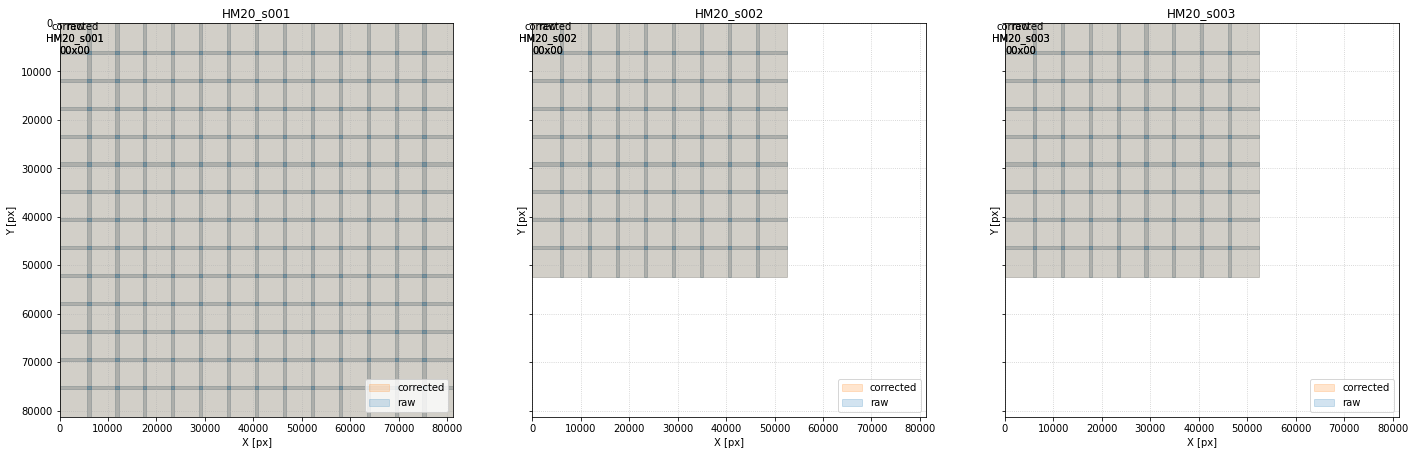

In [74]:
icatapi.plot_tile_map(stacks,
                      render=render)

## 4) Montage
---

Parse transformation data from `.../corrected/montage.xml` file.

In [75]:
# Initialize stacks DataFrame
df_stacks = pd.DataFrame()

# Loop through stacks
for stack in tqdm(stacks):

    # Create stack DataFrame
    df_stack = icatapi.create_stack_DataFrame(stack=stack,
                                              render=render)
    # Edit stack name
    df_stack['stack'] = stack + '_montaged'

    # Loop through section directories
    for z, dir_section in enumerate(dir_sections):

        # Parse montage.xml file
        fp = dir_section / 'corrected/montage.xml'
        soup = Soup(fp.read_text(), 'lxml')

        # Loop through "patches"
        for patch in soup.find_all('t2_patch'):

            # Parse transform data
            M00, M10, M01, M11, B0, B1 = [float(i) for i in re.findall(
                r'-?[\d.]+(?:[Ee]-?\d+)?', patch['transform'])]
            A = AffineModel(M00, M01, M10, M11, B0, B1)

            # Infer stack index
            row, col = [int(i) for i in patch['title'].split('_')[:2]]
            i = df_stack.loc[(df_stack['z'] == z) &\
                             (df_stack['imageRow'] == row) &\
                             (df_stack['imageCol'] == col)].index.item()
            df_stack.at[i, 'tforms'] = [A]

    # 
    df_stacks = pd.concat([df_stacks, df_stack])

# Sneak peak
df_stacks.groupby('stack')\
         .apply(lambda x: x.sample(4))

  0%|          | 0/2 [00:00<?, ?it/s]

/home/akievits/miniconda3/envs/icat/lib/python3.9/site-packages/bs4/builder/__init__.py:545: XMLParsedAsHTMLWarning: It looks like you're parsing an XML document using an HTML parser. If this really is an HTML document (maybe it's XHTML?), you can ignore or filter this warning. If it's XML, you should know that using an XML parser will be more reliable. To parse this document as XML, make sure you have the lxml package installed, and pass the keyword argument `features="xml"` into the BeautifulSoup constructor.
  warnings.warn(
/home/akievits/miniconda3/envs/icat/lib/python3.9/site-packages/bs4/builder/__init__.py:545: XMLParsedAsHTMLWarning: It looks like you're parsing an XML document using an HTML parser. If this really is an HTML document (maybe it's XHTML?), you can ignore or filter this warning. If it's XML, you should know that using an XML parser will be more reliable. To parse this document as XML, make sure you have the lxml package installed, and pass the keyword argument `f

tileId    z   width  height   minint  \
stack                                                                    
corrected_montaged 217  cor-S001-002x003  1.0  6400.0  6400.0  29286.0   
                   334  cor-S002-006x003  2.0  6400.0  6400.0  28386.0   
                   303  cor-S002-002x008  2.0  6400.0  6400.0  28386.0   
                   29   cor-S000-002x001  0.0  6400.0  6400.0  28120.0   
raw_montaged       318  raw-S002-004x005  2.0  6400.0  6400.0  48929.0   
                   206  raw-S001-001x001  1.0  6400.0  6400.0  51662.0   
                   178  raw-S000-012x010  0.0  6400.0  6400.0  49337.0   
                   277  raw-S002-000x000  2.0  6400.0  6400.0  48929.0   

                         maxint     imagePyramid               tforms  \
stack                                                                   
corrected_montaged 217  35745.0  [0, 1, 2, 3, 4]  [M=[[1.000000,0....   
                   334  35707.0  [0, 1, 2, 3, 4]  [M=[[1.000000,0....   
                   303  35707.0  [0, 1, 2, 3, 4]  [M=[[1.000000,0....   
                   29   35585.0  [0, 1, 2, 3, 4]  [M=[[1.000000,0....   
raw_montaged       318  58529.0     [0, 1, 2, 3]  [M=[[1.000000,0....   
                   206  59511.0     [0, 1, 2, 3]  [M=[[1.000000,0....   
                   178  58292.0     [0, 1, 2, 3]  [M=[[1.000000,0....   
                   277  58529.0     [0, 1, 2, 3]  [M=[[1.000000,0....   

                                     stack  sectionId  imageRow  imageCol  
stack                                                                      
corrected_montaged 217  corrected_montaged  HM20_s002         2         3  
                   334  corrected_montaged  HM20_s003         6         3  
                   303  corrected_montaged  HM20_s003         2         8  
                   29   corrected_montaged  HM20_s001         2         1  
raw_montaged       318        raw_montaged  HM20_s003         4         5  
                   206        raw_montaged  HM20_s002         1         1  
                   178        raw_montaged  HM20_s001        12        10  
                   277        raw_montaged  HM20_s003         0         0

#### Upload montage stacks

In [76]:
# Loop through stacks
for stack, df_stack in tqdm(df_stacks.groupby('stack')):

    # Set stack resolution
    Rx = 4
    Ry = 4
    Rz = 100

    # Create stacks
    upload_stack_DataFrame(df=df_stack,
                           name=stack,
                           stackResolutionX=Rx,
                           stackResolutionY=Ry,
                           stackResolutionZ=Rz,
                           render=render)

  0%|          | 0/2 [00:00<?, ?it/s]

Creating tile specifications for corrected_montaged...
Importing tile specifications to corrected_montaged...
org.janelia.render.client.ImportJsonClient

  Running: /home/catmaid/render/deploy/jdk1.8.0_131/bin/java -cp /home/catmaid/render/render-ws-java-client/target/render-ws-java-client-2.0.1-SNAPSHOT-standalone.jar -Xms2G -Xmx2G -Djava.awt.headless=true -XX:+UseSerialGC org.janelia.render.client.ImportJsonClient --baseDataUrl http://sonic.tnw.tudelft.nl:8080/render-ws/v1 --owner akievits --project 20220601_UMCU --stack corrected_montaged /tmp/tmpqb9kuzz3.json


14:57:47.754 [main] INFO  [org.janelia.render.client.ClientRunner] run: entry
14:57:47.915 [main] INFO  [org.janelia.render.client.ImportJsonClient] runClient: entry, parameters={
  "renderWeb" : {
    "baseDataUrl" : "http://sonic.tnw.tudelft.nl:8080/render-ws/v1",
    "owner" : "akievits",
    "project" : "20220601_UMCU"
  },
  "tileSpecValidator" : { },
  "stack" : "corrected_montaged",
  "tileFiles" : [
    "/tmp/tmpqb9k

#### Inspect

  0%|          | 0/3 [00:00<?, ?it/s]

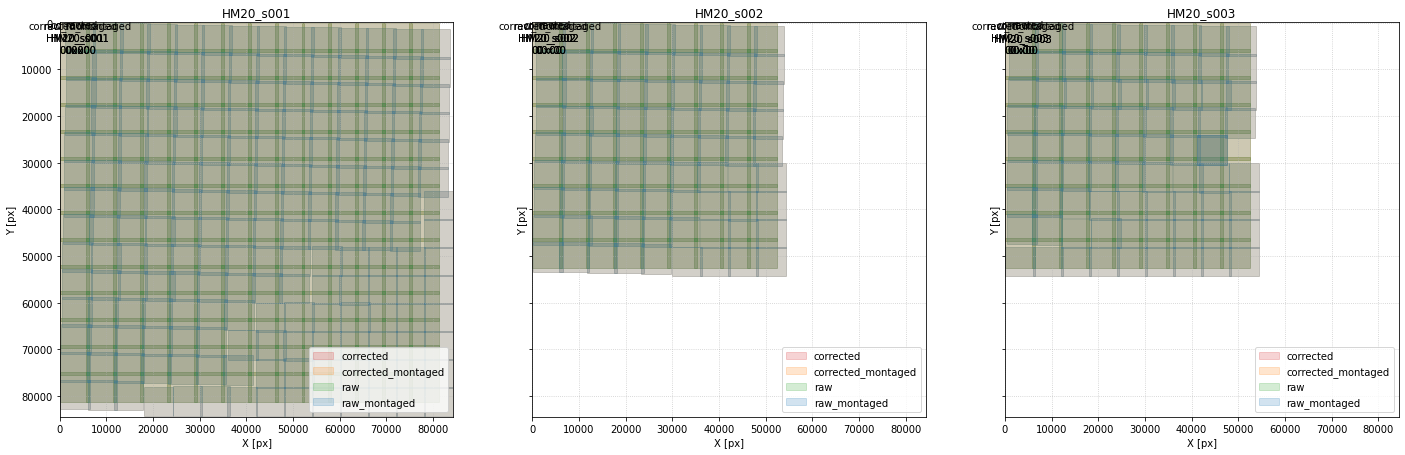

In [77]:
stacks_2_plot = renderapi.render.get_stacks_by_owner_project(render=render)
icatapi.plot_tile_map(stacks_2_plot,
                      render=render)

  0%|          | 0/12 [00:00<?, ?it/s]

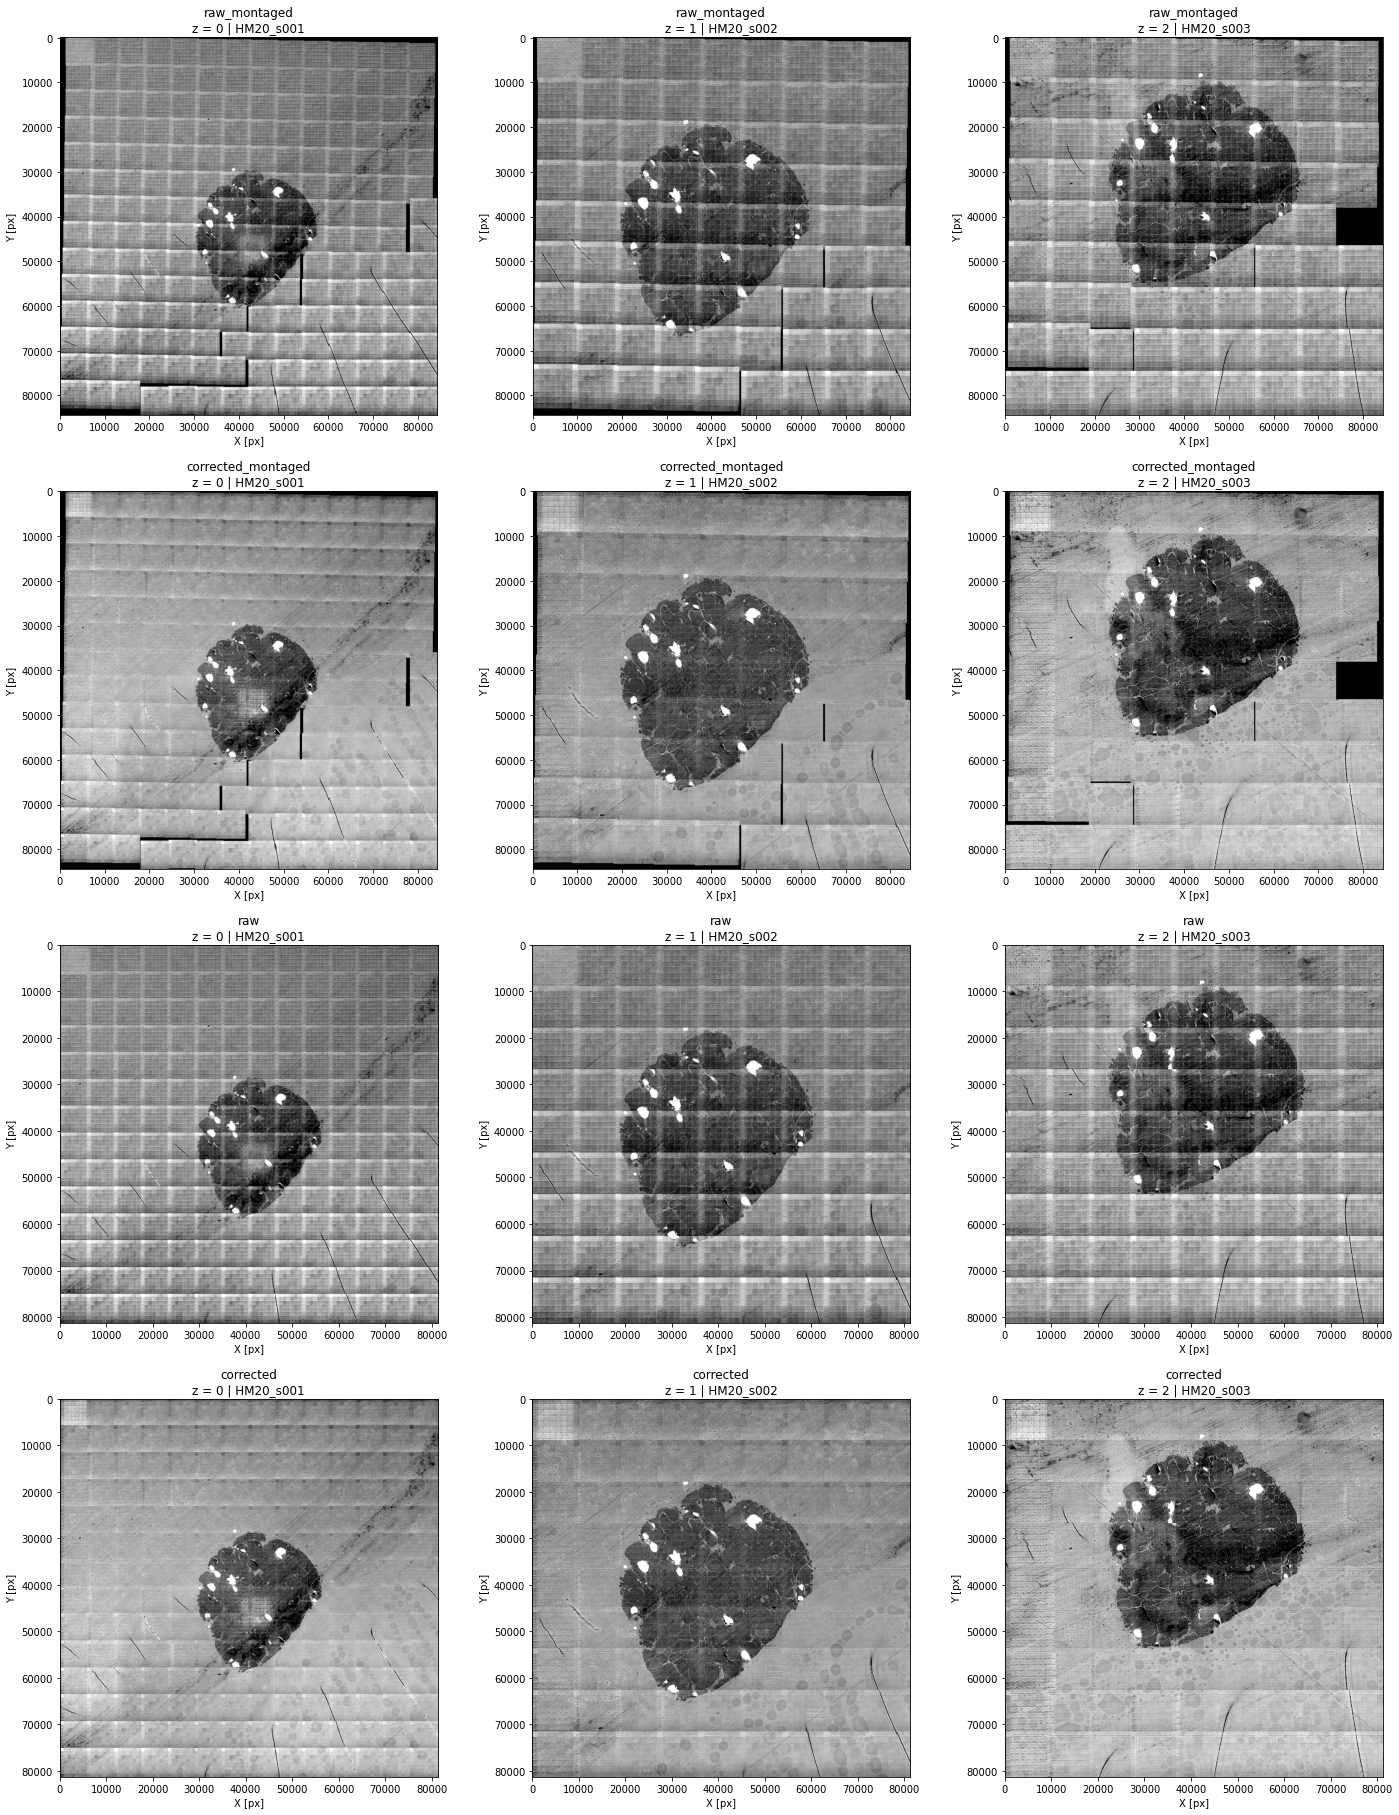

In [78]:
icatapi.plot_stacks(stacks_2_plot,
                    maxTileSpecsToRender=1000,
                    render=render)